# Introduction

In this tutorial, we'll be walking through the Keras code behind creating a convolutional neural network. Understanding the code and concepts will require familiarity in creating neural networks. If you want to review or learn about that, the notes from last week's workshop are [here](https://github.com/uclaacmai/tf-workshop-series/tree/master/week6-neural-nets).


In [12]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
import numpy as np
np.random.seed(1000)

Let's make a simple API call to get our dataset. Today, we'll be working with CIFAR 10 - a slightly more interesting dataset than MNIST, in that we have 3 channels instead of a single channel, and much more training data. Our images and dataset size are still comparatively small, however, making this a good dataset to use for demonstration purposes.

Specifically, the code below will return 2 tuples:`(x_train, x_test)`: array of RGB image data with shape (num_samples, 32, 32, 3). and `(y_train, y_test)`: array of category labels (integers in range 0-9) with shape (num_samples, 1).

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # may take a while to download


In [4]:
print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 1)


In [5]:
print(x_test.shape, y_test.shape)

(10000, 32, 32, 3) (10000, 1)


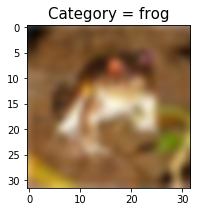

In [36]:
import re
import matplotlib.pyplot as plt
%matplotlib inline
def plot_CIFAR(image_data, image_label):
    label_dict = {0: 'airplane', 1:'automobile', 2:'bird',
                  3: 'cat', 4:'deer', 5: 'dog', 6:'frog',
                  7:'horse', 8:'ship', 9: 'truck'}
    img = image_data
    title = re.sub('[!@#$b]', '', str(label_dict[image_label]))
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    ax.imshow(img,interpolation='bicubic')
    ax.set_title('Category = '+ title,fontsize =15)
    plt.show()

image, label = x_train[0], y_train[0]
label = [i for i, val in enumerate(label) if val == 1][0]
plot_CIFAR(image,label)

We need to one-hot encode our labels, so that we can run softmax on our output, which will be of shape $1 * 10$.

In [21]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Defining the AlexNet Model

AlexNet was a major breakthrough in deep learning in 2012, which revived the interest in neural network based models. It's comparatively simple compared to the convolutional neural networks used today, but obtains high accuracy on image classification problems. The full paper is [here](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf). Today, we'll implement a version of the AlexNet model that aims to replicate the model described in the paper.


In [15]:
def alexnet_model(img_shape=(32,32,3), n_classes=10, l2_reg=0., weights=None):
    alexnet = Sequential()
    # layer 1
    # note: 11x11 changed to 7x7
    alexnet.add(Conv2D(96, (7, 7), input_shape=img_shape, padding='same', kernel_regularizer=l2(l2_reg)))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2,2))) # implicit stride of 1 creates overlapping pooling
    
    # layer 2
    alexnet.add(Conv2D(256, (5,5), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2,2)))
    
    # layer 3
    alexnet.add(ZeroPadding2D((1, 1)))
    alexnet.add(Conv2D(512, (3, 3), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2, 2)))
    
    # layer 4
    alexnet.add(ZeroPadding2D((1, 1)))
    alexnet.add(Conv2D(1024, (3, 3), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    
    # layer 5
    alexnet.add(ZeroPadding2D((1, 1)))
    alexnet.add(Conv2D(1024, (3, 3), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2, 2)))
    
    # layer 6
    alexnet.add(Flatten())
    alexnet.add(Dense(3072))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(Dropout(0.5))
    
    # layer 7
    alexnet.add(Dense(4096))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(Dropout(0.5))
    
    # Layer 8
    alexnet.add(Dense(n_classes))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('softmax'))
    
    if weights:
        alexnet.load_weights(weights)
    return alexnet 


In [37]:
model = alexnet_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 32, 32, 96)        14208     
_________________________________________________________________
batch_normalization_35 (Batc (None, 32, 32, 96)        384       
_________________________________________________________________
activation_36 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 256)       614656    
_________________________________________________________________
batch_normalization_36 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
activation_37 (Activation)   (None, 16, 16, 256)       0         
__________

In [17]:
model = alexnet_model()
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 96)        14208     
_________________________________________________________________
batch_normalization_27 (Batc (None, 32, 32, 96)        384       
_________________________________________________________________
activation_28 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 256)       614656    
_________________________________________________________________
batch_normalization_28 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
activation_29 (Activation)   (None, 16, 16, 256)       0         
__________

In [22]:
model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test),
          )
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/1
  384/50000 [..............................] - ETA: 22530s - loss: 2.2360 - acc: 0.2109

KeyboardInterrupt: 